# Notebook 22: Fitting GSMF parameters

Taking into consideration the large amount of existing works dedicated to modelling the GSMF at different redshift ranges, employing different methods and obtaining differing results, Cruslinska et al. (2019) opts to, instead of choosing a single GSMF for each redshift interval, build a "mean GSMF" from a collection of different works. These works all have in common modelling the GSMF as a (sometimes double) Schechter function, defined by three parameters. These are binned into a few different redshift intervals, and within each bin the GSMF is defined as a Schechter function with its paremeters being the average of the results from the works within that bin.

Because Curslinska et al. (2019) only provide one of the three parameters for each GSMF that goes into the construction of the "mean GSMF", we have two options with regards to reproducing this GSMF: recovering the original parameters from the source papers, or fitting a Schechter function for each curve plotted in the paper. Because, when attempted, the first option has deviated considerably from the relations plotted in the paper, we opt for the second option, which is implemented here.

## Prelude

In [1]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
import pickle

import sys
sys.path.append('../src')
from imf import GSMF
from constants import CHR19_GSMF, papers_CHR19_GSMF, ZOH_SUN

In [2]:
LN10 = np.log(10)
LOGE = np.log10(np.e)

In [3]:
DATA_PATH = Path('..', 'data')
GSMF_PATH = Path(DATA_PATH, 'GSMF')
SCHECHTER_PARAMS_PATH = Path(DATA_PATH, 'schechter_params.pkl')

In [4]:
csv_files = list(GSMF_PATH .glob('*.csv'))

## Loading the data

In [5]:
z_gsmf_array = np.empty((0,2), np.float64)

for file in csv_files:
    z = int(file.stem.lstrip('z'))
    with file.open('r') as f:
        array = np.genfromtxt(f, delimiter=',')
        z_gsmf = np.array([[z, array]])
    z_gsmf_array = np.append(z_gsmf_array, z_gsmf, axis=0)

/tmp/ipykernel_69726/627312126.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_gsmf = np.array([[z, array]])


In [6]:
sorted_indexes = np.argsort(z_gsmf_array[:,0])

z_gsmf_array = np.array([z_gsmf_array[i] for i in sorted_indexes])

In [7]:
for i, z_gsmf in enumerate(z_gsmf_array):
    z = z_gsmf[0]
    gsmf = z_gsmf[1]
    m_th = GSMF(z).logmass_threshold
    new_gsmf = np.empty((0,2), np.float64)
    for row in gsmf:
        if row[0] > m_th:
            new_gsmf = np.append(new_gsmf, [row], axis=0)
    z_gsmf_array[i][1] = new_gsmf

Below we have the data extracted from the paper for the high mass range. The low mass range is given by a simple power law which we can implement directly and thus presents no issues.

Text(0.5, 1.0, 'Galactic stellar mass function (GSMF) in the high mass range')

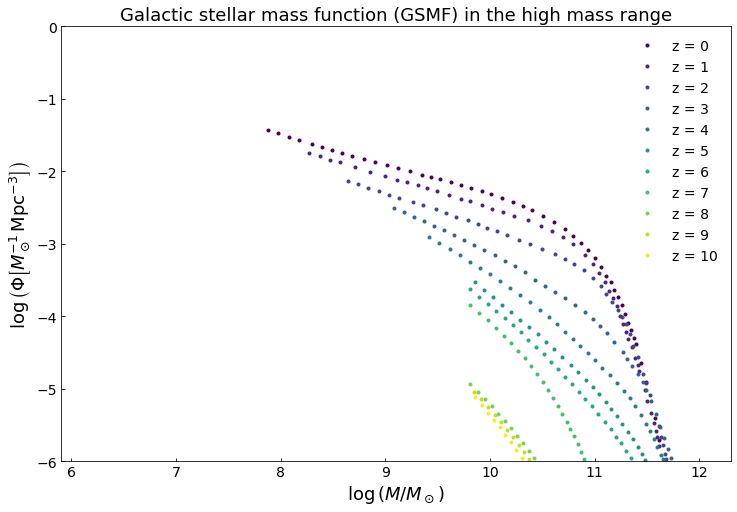

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = 10

for z_gsmf in z_gsmf_array:
    z = z_gsmf[0]
    gsmf = z_gsmf[1]
    
    color = cm.viridis(z/color_norm)
    ax.plot(gsmf[:,0], gsmf[:,1], '.', c=color, label=f'z = {z}', lw=2.2)
    
ax.legend(loc='upper right', frameon=False, fontsize=14)

ax.set_ylim(-6, 0)
ax.set_xlim(5.9, 12.3)
ax.tick_params(axis='both', labelsize=14, direction='in')

ax.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(\Phi\left[M_\odot^{-1}\,\mathrm{Mpc}^{-3}\right]\right)$', fontsize=18)
ax.set_title('Galactic stellar mass function (GSMF) in the high mass range', fontsize=18)

#### Fitting a Schechter function

In [9]:
schechter_params = []

for i, z_gsmf in enumerate(z_gsmf_array):
    alpha = np.abs(papers_CHR19_GSMF[i,1][0])
    z = z_gsmf[0]
    gsmf_points = z_gsmf[1]
    gsmf = GSMF(z)
    
    m_th = gsmf.logmass_threshold
    gsmf_points = np.array([gsmf_point for gsmf_point in gsmf_points if gsmf_point[0] >= m_th])
    
    X = gsmf_points[:, 0]
    Y = gsmf_points[:, 1]
    def f(m, a, phi, m_co): return gsmf._schechter(m, -a, -phi, m_co)

    params, pcovs = curve_fit(f, X, Y, 
                              p0=(alpha, 4, 11), 
                              bounds=([1.3, 1, 9], [2.5, 7, 12]))
    
    params[0] = -params[0]
    params[1] = -params[1]
    params = tuple(params)
    
    schechter_params.append([z, tuple(params)])
    
schechter_params = np.array(schechter_params, dtype=object)

Run the code below if you want to resave the parameter data.

Below we see the resulting fits as full lines, overlaid on the data from the paper.

Text(0.5, 1.0, 'Galactic stellar mass function (GSMF) in the high mass range')

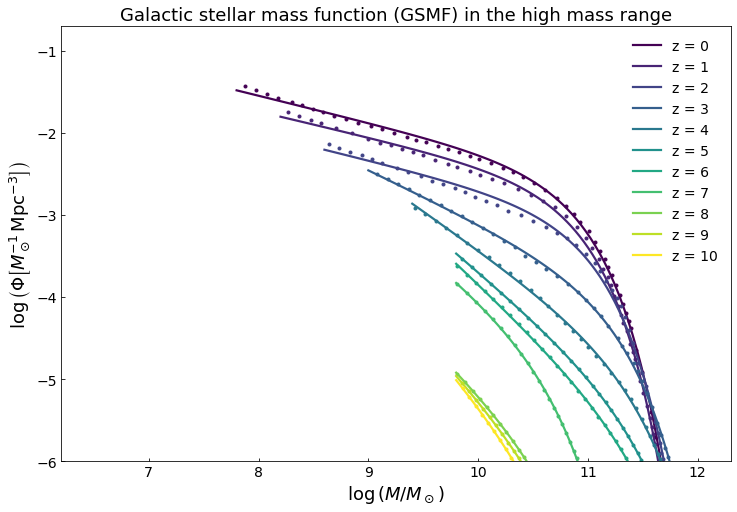

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = 10
masses = np.linspace(6, 12, 100)

for params, gsmf_points in zip(schechter_params, z_gsmf_array[:,1]):
    [z, params] = params
    gsmf = GSMF(z)
    
    m_th = gsmf.logmass_threshold
    masses = np.linspace(m_th, 12, 100)
    gsmfs = np.array([gsmf._schechter(m, *params) for m in masses])
    
    color = cm.viridis(z/color_norm)
    ax.plot(masses, gsmfs, '-', c=color, label=f'z = {z}', lw=2.2)
    ax.plot(gsmf_points[:,0], gsmf_points[:,1], '.', c=color)
    
    
ax.legend(loc='upper right', frameon=False, fontsize=14)

ax.set_ylim(-6, -0.7)
ax.set_xlim(6.2, 12.3)
ax.tick_params(axis='both', labelsize=14, direction='in')

ax.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(\Phi\left[M_\odot^{-1}\,\mathrm{Mpc}^{-3}\right]\right)$', fontsize=18)
ax.set_title('Galactic stellar mass function (GSMF) in the high mass range', fontsize=18)

Because the threshold mass between the power law at low masses and the Schechter function at high masses is calculated per redshift, it is important to verify that it is behaving properly. Below, the calculated threshold is shown as the dashed vertical line.

Text(0.5, 1.0, 'Galactic stellar mass function (GSMF) in the high mass range')

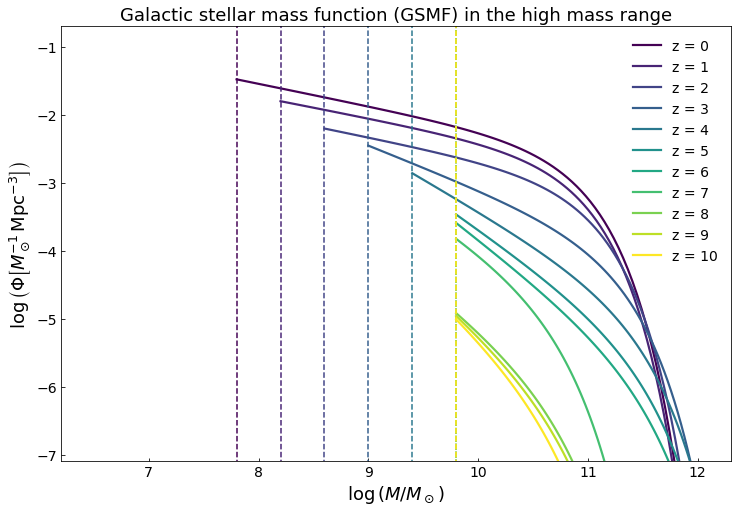

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = 10
masses = np.linspace(6, 12, 100)

for gsmf_data in CHR19_GSMF:
    z = gsmf_data[0]
    params = gsmf_data[1]
    gsmf = GSMF(z)
    
    m_th = gsmf.logmass_threshold
    masses = np.linspace(m_th, 12, 100)
    gsmfs = np.array([gsmf._schechter(m, *params) for m in masses])
    
    color = cm.viridis(z/color_norm)
    ax.plot(masses, gsmfs, '-', c=color, label=f'z = {z}', lw=2.2)
    ax.vlines(m_th, -8, 0, linestyles='--', color=color)
    
#for z_gsmf in z_gsmf_array:
#    z = z_gsmf[0]
#    gsmf_points = z_gsmf[1]
#    gsmf = GSMF(z)
    
#    color = cm.viridis(z/color_norm)
#    ax.plot(gsmf_points[:,0], gsmf_points[:,1], '.', c=color)
    
ax.legend(loc='upper right', frameon=False, fontsize=14)

ax.set_ylim(-7.1, -0.7)
ax.set_xlim(6.2, 12.3)
ax.tick_params(axis='both', labelsize=14, direction='in')

ax.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(\Phi\left[M_\odot^{-1}\,\mathrm{Mpc}^{-3}\right]\right)$', fontsize=18)
ax.set_title('Galactic stellar mass function (GSMF) in the high mass range', fontsize=18)

#### Testing the GSMF class as-intended

The full `GSMF` class should be able to interpolate between the available redshifts to any value of interest, as well as enforce continuity between the low-mass power-law and the high-mass Schechter function. Below we verify that it is working as intended for a full range of masses.

In [12]:
z = 1

gsmf = GSMF(z)

In [13]:
gsmf.logmass_threshold

8.2

In [14]:
gsmf.power_law_index

-1.45

In [15]:
gsmf.gsmf(10)

array([-2.4376159])

In [16]:
test_zs = np.arange(0, 11, 1)
test_masses = np.linspace(6, 12, 100)

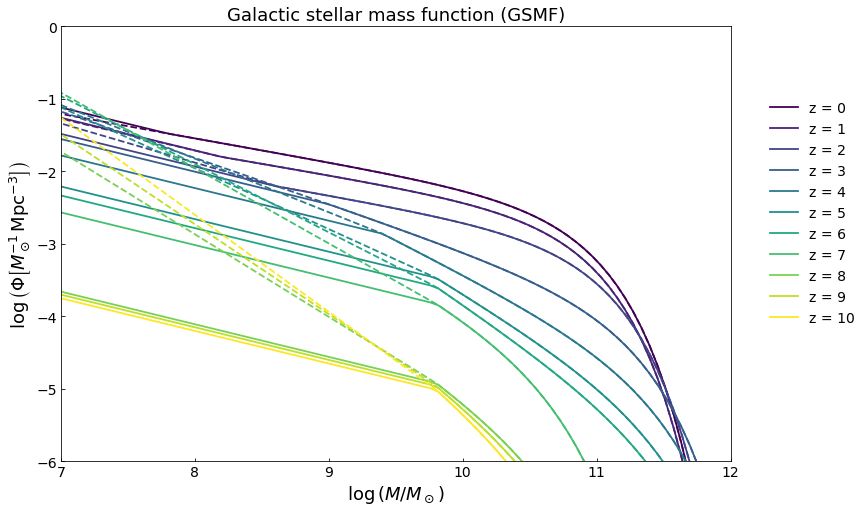

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
color_norm = test_zs.max()-test_zs.min()

for z in test_zs:
    gsmf1 = GSMF(z, True)
    gsmfs1 = np.array([gsmf1.gsmf(m) for m in test_masses])
    
    gsmf2 = GSMF(z, False)
    gsmfs2 = np.array([gsmf2.gsmf(m) for m in test_masses])
    
    color = cm.viridis(z/color_norm)
    ax.plot(test_masses, gsmfs1, '-', c=color, label=f'z = {z}', lw=1.8)
    ax.plot(test_masses, gsmfs2, '--', c=color, lw=1.8)
    
for z_gsmf in z_gsmf_array:
    z = z_gsmf[0]
    gsmf_points = z_gsmf[1]
    gsmf = GSMF(z)
    
    color = cm.viridis(z/color_norm)
    #ax.plot(gsmf_points[:,0], gsmf_points[:,1], '.', c=color)
    
ax.legend(loc=(1.05, 0.3), frameon=False, fontsize=14, ncol=1)

ax.set_ylim(-6, 0)
ax.set_xlim(7, 12)
ax.tick_params(axis='both', labelsize=14, direction='in')

ax.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(\Phi\left[M_\odot^{-1}\,\mathrm{Mpc}^{-3}\right]\right)$', fontsize=18)
ax.set_title('Galactic stellar mass function (GSMF)', fontsize=18)

plt.savefig('GSMFmodel.png')

Nevermind the messy look, we just needed to check that the class performed adequately. It seems like it does!

#### Rewriting the GSMF as a function of redshift and metallicity

The quantity we will need in order to get the SFR from the SFRD is the number density $n$ of galaxies with a given metallcity at a given redshfit. Thus it is necessary to move from writing the GSMF as a function of mass to the GSMF as a function of metallicity. This association is given by the MZR at a fixed redshift, with each stellar mass is associated to a particular metallicity; although real galaxies show a level of dispersion around the MZR, here we will treat it as one-to-one relation.

For a galaxy sampling approach, the GSMF can also be employed in order to construct a representative finite sample of galaxies. This is explored in Notebook 31.

In [18]:
sys.path.append('../legacy')
from sfr_old import MZR, SFZR

/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
/home/lucasmdesa/git_repos/environIMF/notebooks/../legacy/sfr_old.py:264: RuntimeWarning: invalid value encountered in double_scalars
  return self.m_to * (10**(self.z_a-zoh+dz)-1)**(-1/self.gamma)
/home/luca

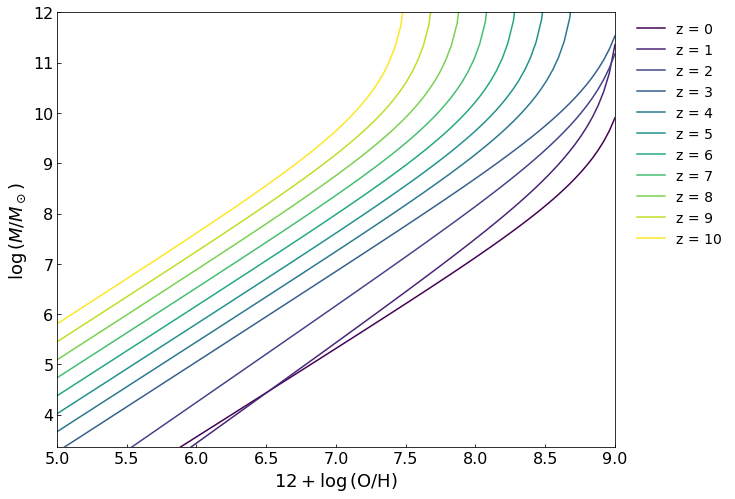

In [19]:
demo_redshifts = np.linspace(0,10, 11)
demo_zohs = np.linspace(5, 9, 100)
color_norm = demo_redshifts.max() - demo_redshifts.min()

fig, ax = plt.subplots(figsize=(10,8))

for redshift in demo_redshifts:
    sfzr = SFZR(np.array([redshift]))
    sfzr.set_MZR_params()
    mzr = MZR(redshift, *sfzr.mzr_params[0])
    
    demo_mzr = np.array([mzr.m(zoh) for zoh in demo_zohs])
    
    color = cm.viridis(redshift/color_norm)
    ax.plot(demo_zohs, np.log10(demo_mzr), c=color, label=f'z = {redshift:.0f}')
    
    ax.set_ylabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
    ax.set_ylim(3.35, 12)
    ax.set_xlabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
    ax.set_xlim(5,9)
    #ax.set_yticks([10**x for x in np.arange(4, 13, 1)])
   # ax.set_yticklabels([x for x in np.arange(4, 13, 1)])
    
    ax.tick_params(axis='both', direction='in', labelsize=16)  
    ax.legend(loc=(1.03,0.45), frameon=False, fontsize=14)

Say we want the number density of galaxies between 0 and 10 redshift and $\mathrm{Z}_{\mathrm{O}/\mathrm{H}}=5.85$. By using the MZR, we can find that

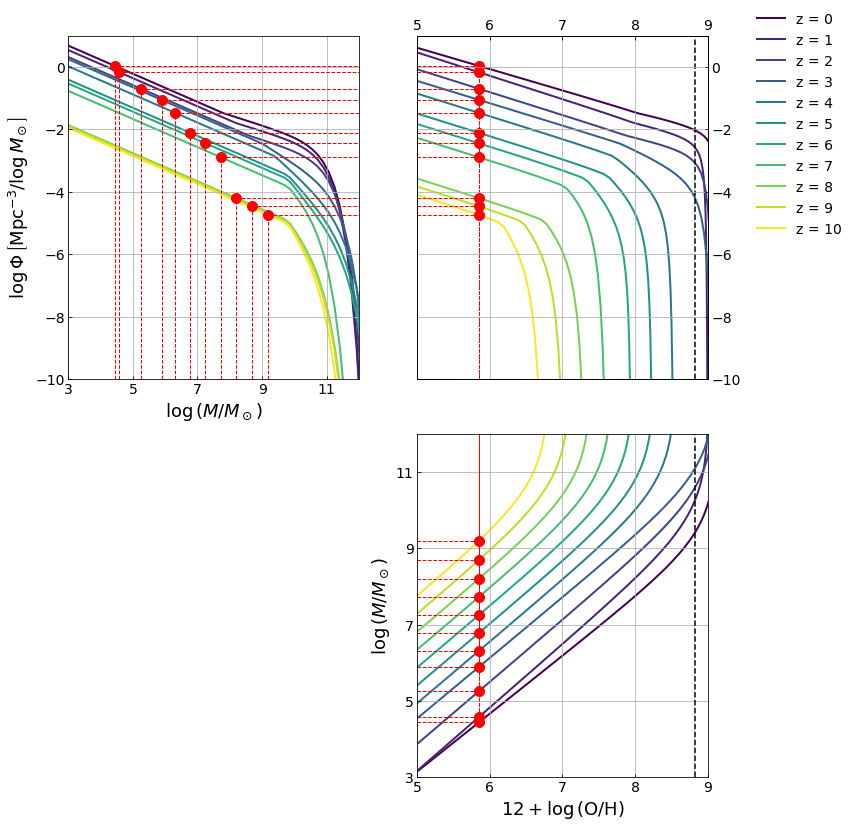

In [20]:
fig = plt.figure(figsize=(12,12), tight_layout=True)
plot_masses = np.linspace(3, 20, 100)

MZR_model = 'T04'
zs = np.arange(0,11,1)
zoh = 5.85

mmax = 12
mmin = 3
zohmax = 9
zohmin = 5
gsmfmax = 1
gsmfmin = -10


ax1 = fig.add_subplot(2, 2, 1) # top left subplot; GSMF
ax2 = fig.add_subplot(2, 2, 2) # top right subplot; "GZF"
ax4 = fig.add_subplot(2, 2, 4) # bottom right subplot; MZR


cnorm = zs.max() - zs.min()
if cnorm == 0:
    cnorm = 1


solution_gsmfs = []
solution_masses = []
for z in zs:
    gsmf = GSMF(z)
    plot_gsmfs = np.array([gsmf.gsmf(m) for m in plot_masses])

    sfzr = SFZR(np.array([z]), MZR_model)
    sfzr.set_MZR_params()
    mzr = MZR(z, *sfzr.mzr_params[0])
    plot_zohs = np.array([mzr.zoh(10**m) for m in plot_masses])
    
    solution_mass = np.log10(mzr.m(zoh))
    solution_gsmf = gsmf.gsmf(solution_mass)
    solution_gsmfs.append(solution_gsmf)
    solution_masses.append(solution_mass)
    
    color = cm.viridis((z-zs.min())/cnorm)
    
    ax1.plot(plot_masses, plot_gsmfs, c=color, lw=2, label=f'z = {z:.0f}', zorder=1)
    ax1.vlines(solution_mass, gsmfmin, solution_gsmf, linestyle='--', color='red', lw=1, zorder=2)
    ax1.hlines(solution_gsmf, solution_mass, mmax, linestyle='--', color='red', lw=1, zorder=2)
    ax1.plot(solution_mass, solution_gsmf, 'r.', markersize=20)

    ax4.plot(plot_zohs, plot_masses, c=color, lw=2, label=f'z = {z:.0f}',  zorder=1)
    ax4.vlines(zoh, solution_mass, mmax, linestyle='--', color='red', lw=1, zorder=2)
    ax4.hlines(solution_mass, zohmin, zoh, linestyle='--', color='red', lw=1, zorder=2)
    ax4.plot(zoh, solution_mass, 'r.', markersize=20)

    ax2.plot(plot_zohs, plot_gsmfs, c=color, lw=2, label=f'z = {z:.0f}', zorder=1)
    ax2.vlines(zoh, gsmfmin, solution_gsmf, linestyle='--', color='red', lw=1, zorder=2)
    ax2.hlines(solution_gsmf, zohmin, zoh, linestyle='--', color='red', lw=1, zorder=2)
    ax2.plot(zoh, solution_gsmf, 'r.', markersize=20)

ax2.vlines(ZOH_SUN, gsmfmin, gsmfmax, linestyle='--', color='black')
ax4.vlines(ZOH_SUN, mmin, mmax, linestyle='--', color='black')
    
ax1.set_xlim(mmin, mmax)
ax1.set_ylim(gsmfmin, gsmfmax)
ax1.set_yticks(np.arange(gsmfmin, gsmfmax+1, 2))
ax1.set_xticks(np.arange(mmin, mmax+1, 2))
ax1.set_xlabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax1.set_ylabel(r'$\log\Phi\,\left[\mathrm{Mpc}^{-3}/ \log M_\odot\right]$', fontsize=18) 
ax1.tick_params(which='both', labelsize=14, direction='in')
ax1.grid(visible=True, zorder=0)


ax4.set_xlim(zohmin, zohmax)
ax4.set_ylim(mmin, mmax)
ax4.set_yticks(ax1.get_xticks())
ax4.set_xlabel(r'$12+\log\left(\mathrm{O}/\mathrm{H}\right)$', fontsize=18)
ax4.set_ylabel(r'$\log\left(M/M_\odot\right)$', fontsize=18)
ax4.tick_params(which='both', labelsize=14, direction='in')
ax4.grid(visible=True, zorder=0)


ax2.set_xlim(zohmin, zohmax)
ax2.set_ylim(gsmfmin, gsmfmax)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.legend(loc=(1.15, 0.4), frameon=False, fontsize=14)


ax2x = ax2.twiny()
ax2x.set_xlim(zohmin, zohmax)
ax2x.set_xticks(ax4.get_xticks())
ax2x.tick_params(which='both', labelsize=14, direction='in')
ax2x.grid(visible=True, zorder=0)

ax2y = ax2.twinx()
ax2y.set_ylim(-9, 1)
ax2y.set_yticks(ax1.get_yticks())
ax2y.tick_params(which='both', labelsize=14, direction='in')
ax2y.grid(visible=True, zorder=0)

In [21]:
for z, loggsmf, logm in zip(zs, solution_gsmfs, solution_masses):
    logdndlogm = np.float64(loggsmf)
    logdndm = logdndlogm - logm - np.log10(LN10)
    print(f'At z={z}, log(dN/dlogM) = {logdndlogm}, or log(dN/dM) = {logdndm}')

At z=0, log(dN/dlogM) = 0.035023978992125226, or log(dN/dM) = -4.762999728789383
At z=1, log(dN/dlogM) = -0.16994643524195324, or log(dN/dM) = -5.1084197116252295
At z=2, log(dN/dlogM) = -0.6962652436755827, or log(dN/dM) = -6.310552448275497
At z=3, log(dN/dlogM) = -1.0532999052887586, or log(dN/dM) = -7.302346142838648
At z=4, log(dN/dlogM) = -1.4691632634024365, or log(dN/dM) = -8.139858723430269
At z=5, log(dN/dlogM) = -2.108552001721236, or log(dN/dM) = -9.248305562983841
At z=6, log(dN/dlogM) = -2.444192392054588, or log(dN/dM) = -10.054261341480181
At z=7, log(dN/dlogM) = -2.890752835136376, or log(dN/dM) = -10.973608907076313
At z=8, log(dN/dlogM) = -4.198661315813519, or log(dN/dM) = -12.759202403061328
At z=9, log(dN/dlogM) = -4.459808096026526, or log(dN/dM) = -13.507894137569721
At z=10, log(dN/dlogM) = -4.738329630871054, or log(dN/dM) = -14.294458836054636
